In [1]:
#Let us import some important libraries
## For data ANALYSIS
import pandas as pd
import numpy as np
## For plotting
import matplotlib.pyplot as plt
## For outliers detection
from sklearn import preprocessing, svm
## For stationarity test and decomposition
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#LET US LOAD THE TIME-SERIES DATA OF THE SALES OF DTC-BRAND FROM 1-JAN-2021 TO 3-MAY-2021 AS PROVIDED. NOTE: THIS DATA IS ALREADY
# ANALYZED AND CLEANED AND SORT ACCORDING TO THE DATE
dtf = pd.read_csv('sample_data.csv')
dtf

,Unnamed: 0,day,cancelled,financial_status,fulfillment_status,order_id,order_name,sale_line_type,sale_kind,billing_city,...,total_sales,average_order_value,total_tips,total_cost,gross_profit,gross_margin,units_per_transaction,gift_card_discounts,net_quantity,average_units_ordered
0,0,01/01/21,No,pending,fulfilled,2.963580e+12,GN1889,shipping,order,Kanyakumari,...,30.00,0.00,0,0,0,0,0,0,0,0
1,1,01/01/21,No,pending,fulfilled,2.963580e+12,GN1889,product,order,Kanyakumari,...,342.95,342.95,0,0,0,0,1,0,1,1
2,2,01/01/21,No,paid,fulfilled,2.963240e+12,GN1887,shipping,order,Visakhapatnam,...,30.00,0.00,0,0,0,0,0,0,0,0
3,3,01/01/21,No,pending,fulfilled,2.963590e+12,GN1890,shipping,order,Colva,...,30.00,0.00,0,0,0,0,0,0,0,0
4,4,01/01/21,No,paid,fulfilled,2.963060e+12,GN1886,shipping,order,Hyderabad,...,0.00,0.00,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,4015,05/03/21,No,paid,unfulfilled,3.782120e+12,GN3482,product,order,Mumbai,...,272.00,272.00,0,0,0,0,1,0,1,1
4016,4016,05/03/21,Yes,pending,fulfilled,3.763240e+12,GN3341,product,return,Palani,...,-625.00,0.00,0,0,0,0,0,0,-1,0
4017,4017,05/03/21,No,pending,unfulfilled,3.781940e+12,GN3477,shipping,order,Mumbai,...,0.00,0.00,0,0,0,0,0,0,0,0
4018,4018,05/03/21,No,paid,unfulfilled,3.782120e+12,GN3482,shipping,order,Mumbai,...,0.00,0.00,0,0,0,0,0,0,0,0


In [3]:
df_test = dtf[['day','total_sales']]  #later will be used for forecasting
df_test = df_test.groupby('day')['total_sales'].sum().reset_index()
df_test

,day,total_sales
0,01/01/21,7866.70
1,01/02/21,7458.70
2,01/03/21,4840.25
3,01/04/21,8985.40
4,01/05/21,6873.30
...,...,...
118,04/29/21,17124.25
119,04/30/21,16832.35
120,05/01/21,3338.90
121,05/02/21,8806.05


In [4]:
dtf.describe()

,Unnamed: 0,order_id,product_price,variant_id,orders,gross_sales,discounts,returns,net_sales,shipping,...,total_sales,average_order_value,total_tips,total_cost,gross_profit,gross_margin,units_per_transaction,gift_card_discounts,net_quantity,average_units_ordered
count,4020.00000,4.020000e+03,4020.000000,4.020000e+03,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,...,4020.000000,4020.000000,4020.0,4020.0,4020.0,4020.0,4020.000000,4020.0,4020.000000,4020.000000
mean,2009.50000,3.472067e+12,316.672264,2.039399e+13,0.606219,356.433818,-67.057371,-2.782706,286.593741,1.203980,...,297.659353,299.307065,0.0,0.0,0.0,0.0,0.739055,0.0,0.712935,0.739055
std,1160.61837,3.320422e+11,315.294259,1.583691e+13,0.488648,728.520322,212.099096,45.825158,684.255744,5.790846,...,691.173195,688.864460,0.0,0.0,0.0,0.0,1.384454,0.0,1.414805,1.384454
min,0.00000,2.962890e+12,0.000000,0.000000e+00,0.000000,0.000000,-4050.000000,-1008.100000,-1008.100000,-30.000000,...,-1008.100000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,-3.000000,0.000000
25%,1004.75000,3.039805e+12,0.000000,0.000000e+00,0.000000,0.000000,-46.050000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
50%,2009.50000,3.674440e+12,343.000000,3.210270e+13,1.000000,337.500000,0.000000,0.000000,170.500000,0.000000,...,187.500000,187.500000,0.0,0.0,0.0,0.0,1.000000,0.0,1.000000,1.000000
75%,3014.25000,3.726998e+12,531.000000,3.276660e+13,1.000000,533.890000,0.000000,0.000000,483.050000,0.000000,...,485.450000,485.450000,0.0,0.0,0.0,0.0,1.000000,0.0,1.000000,1.000000
max,4019.00000,3.782460e+12,2137.000000,3.940870e+13,1.000000,38232.000000,0.000000,1039.750000,36320.400000,30.000000,...,36320.400000,36320.400000,0.0,0.0,0.0,0.0,72.000000,0.0,72.000000,72.000000


In [5]:
#GROUP THE DATA ACCORDING TO THE DATE AND SUM THE TOTAL SALE FOR EACH DAY
ts = dtf.groupby("day")["total_sales"].sum().rename("sales")
ts

day
01/01/21     7866.70
01/02/21     7458.70
01/03/21     4840.25
01/04/21     8985.40
01/05/21     6873.30
              ...   
04/29/21    17124.25
04/30/21    16832.35
05/01/21     3338.90
05/02/21     8806.05
05/03/21     7268.20
Name: sales, Length: 123, dtype: float64

<AxesSubplot:xlabel='day'>

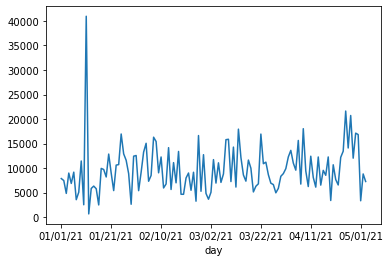

In [6]:
#LET US DO SOME DATA ANALYSIS ON THE DATA
ts.plot()

In [7]:
ts.describe()

count      123.000000
mean      9728.378862
std       5012.467193
min        660.300000
25%       6431.300000
50%       8985.400000
75%      12268.935000
max      40952.950000
Name: sales, dtype: float64

In [8]:
# lET US USE SOME STATITCAL CONCEPTS WHICH ARE USED IN FORECASTING LIKE MOVING AVERAGE AND BLLINGER BAND(Dont know 
#whether it works for sales prediction but picked the idea from general stock prediction and is one of the importan tool for visulisation)
'''
Plot ts with rolling mean and 95% confidence interval with rolling std.
:parameter    
  :param ts: pandas Series    
  :param window: num - for rolling stats
  :param plot_ma: bool - whether plot moving average
  :param plot_intervals: bool - whether plot upper and lower bounds
'''
#lET US SET THE ROLLING WINDOW = 10  SINCE WE HAVE THE DATASET FOR 4 MONTHS WORKING ON THIS INDICATOR SHOULD BE GOOD
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=10, figsize=(15,5)):
    
    rolling_mean = ts.rolling(window=window).mean()    
    rolling_std = ts.rolling(window=window).std()
    plt.figure(figsize=figsize)    
    plt.title(ts.name)    
    plt.plot(ts[window:], label='Actual values', color="black")    
    if plot_ma:        
        plt.plot(rolling_mean, 'g', label='MA'+str(window), color="green")    
    if plot_intervals:
        lower_bound = rolling_mean - (1.96 * rolling_std)
        upper_bound = rolling_mean + (1.96 * rolling_std)
    plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound, color='lightskyblue', alpha=0.4)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

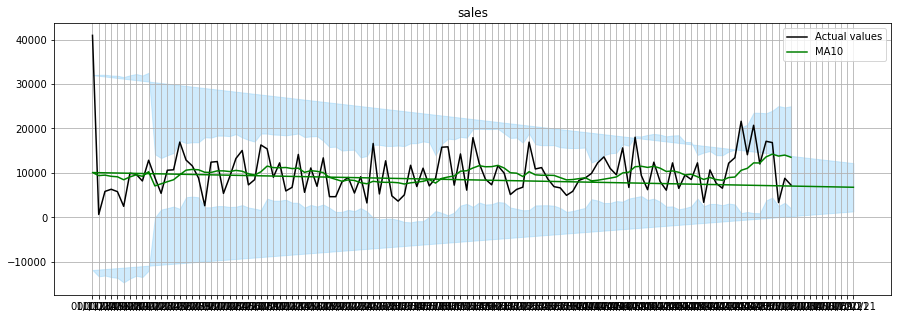

In [9]:
plot_ts(ts, window=10)

<AxesSubplot:>

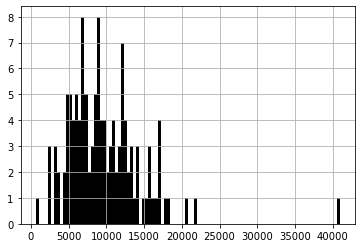

In [10]:
## Plot histogram
ts.hist(color="black", bins=100)

<AxesSubplot:>

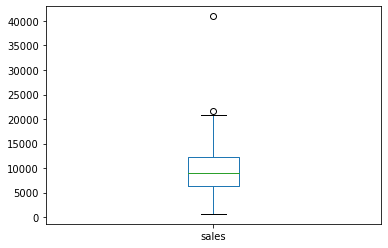

In [11]:
## Boxplot
ts.plot.box()

#we see there are some outliers points from the above plots which might affect our trend pattend and in forecast
#but this method is usefull when we have good notion of the whole data and since we have large data, Lets try to build some 
#algorithm which will detect ouliers automatically and remove them. Once this is done lets try to predict the pattern again 
#without outliers and make some important conclusions. We will use Support Vector Machine(SVM) algorithm to do some analysis
#it will be using clustering algorithm.

In [12]:
'''
Find outliers using sklearn unsupervised support vetcor machine.
:parameter
    :param ts: pandas Series
    :param perc: float - percentage of outliers to look for
:return
    dtf with raw ts, outlier 1/0 (yes/no), numeric index
'''
def find_outliers(ts, perc=0.01, figsize=(15,5)):
    ## fit svm
    scaler = preprocessing.StandardScaler()
    ts_scaled = scaler.fit_transform(ts.values.reshape(-1,1))
    model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
    model.fit(ts_scaled)
    ## dtf output
    dtf_outliers = ts.to_frame(name="ts")
    dtf_outliers["index"] = range(len(ts))
    dtf_outliers["outlier"] = model.predict(ts_scaled)
    dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                              x: 1 if x==-1 else 0)
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(title="Outliers detection: found"
           +str(sum(dtf_outliers["outlier"]==1)))
    ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
            color="black")
    ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
               y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
               color='red')
    ax.grid(True)
    plt.show()
    return dtf_outliers


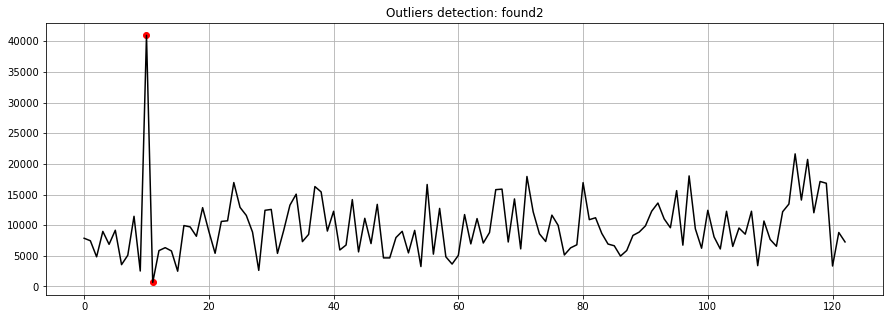

In [13]:
dtf_outliers = find_outliers(ts, perc=0.01)

In [14]:
#SO WE FOUND 2 OUTLIERS IN OURS ANLYSIS. NOW LETS TRY TO REMOVE THEM BY INTERPOLATING.

In [15]:
'''
Interpolate outliers in a ts.
'''
def remove_outliers(ts, outliers_idx, figsize=(15,5)):
    ts_clean = ts.copy()
    ts_clean.loc[outliers_idx] = np.nan
    ts_clean = ts_clean.interpolate(method="linear")
    ax = ts.plot(figsize=figsize, color="red", alpha=0.5,
         title="Remove outliers", label="original", legend=True)
    ts_clean.plot(ax=ax, grid=True, color="black",
                  label="interpolated", legend=True)
    plt.show()
    return ts_clean

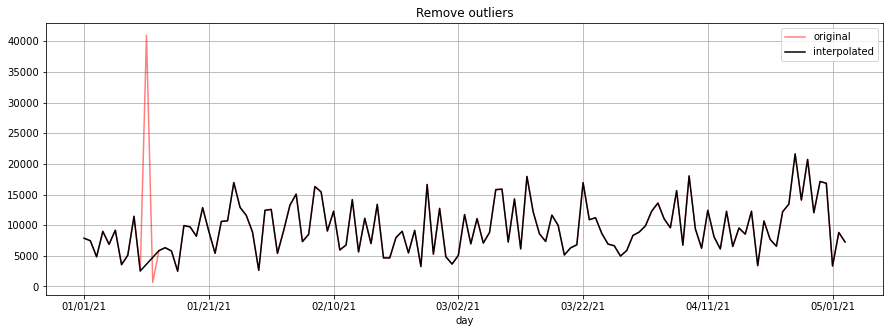

In [16]:
## outliers index position
outliers_index_pos = dtf_outliers[dtf_outliers["outlier"]==1].index
## exclude outliers
ts_clean = remove_outliers(ts, outliers_idx=outliers_index_pos)

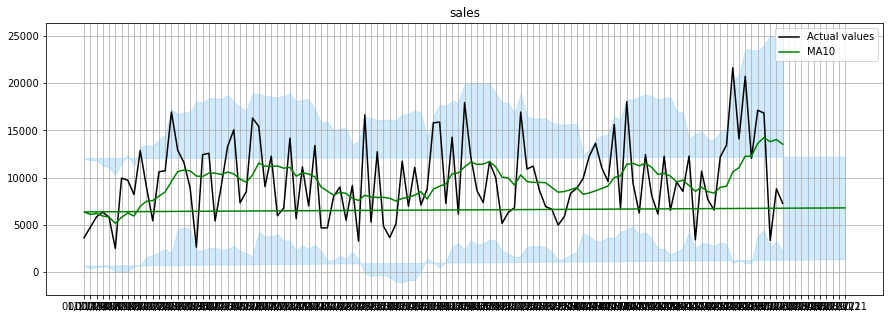

In [17]:
plot_ts(ts_clean, window=10)

CONCLUSION: After comparing the above pattern with the pattern containing outliers we see that above pattern we see that the
    linear trend that we plot has lowered and is almost horizontal or slight increasing. Now this is due to removal of the 
    important points from out dataset. Although trend is showing good trend, but from business perspective it might loose 
    some important information, which are important for forecasting. For example around 10-Jan-2021 the sale was highest and 
    increase suddenly and later droped after few days. Now this information became outlier and lead to lower in MA.

#STATIONARY TEST
A stationary process is a stochastic process whose unconditional joint probability distribution does not change 
when shifted in time. Consequently, parameters such as mean and variance also do not change over time, 
therefore stationary time series are easier to forecast.
The most common test is the Dickey-Fuller test (also called “ADF test”) where the null hypothesis is that 
the time series has a unit root, in other words, that the time series is not stationary. 
We’ll test whether the null hypothesis can be rejected comparing the p-value to a chosen threshold (α), 
so that if the p-value is smaller we can reject the null hypothesis and 
assume that the time series is stationary with a confidence level of 1-α.
p > 0.10 ; weak evidence against H0
0.05< p < 0.10 ;moderate evidence against H0
0.01< p < 0.05 ; strong evidence against H0
p < 0.01 ; very strong evidence against H0

In [18]:
'''
Test stationarity by:
    - running Augmented Dickey-Fuller test wiht 95%
    - plotting mean and variance of a sample from data
    - plottig autocorrelation and partial autocorrelation
'''
def test_stationarity_acf_pacf(ts, sample=0.20, maxlag=10, figsize= (15,10)):
    
    with plt.style.context(style='bmh'):
        ## set figure
        fig = plt.figure(figsize=figsize)
        ts_ax = plt.subplot2grid(shape=(2,2), loc=(0,0), colspan=2)
        pacf_ax = plt.subplot2grid(shape=(2,2), loc=(1,0))
        acf_ax = plt.subplot2grid(shape=(2,2), loc=(1,1))
        
        ## plot ts with mean/std of a sample from the first x% 
        dtf_ts = ts.to_frame(name="ts")
        sample_size = int(len(ts)*sample)
        dtf_ts["mean"] = dtf_ts["ts"].head(sample_size).mean()
        dtf_ts["lower"] = dtf_ts["ts"].head(sample_size).mean() + dtf_ts["ts"].head(sample_size).std()
        dtf_ts["upper"] = dtf_ts["ts"].head(sample_size).mean() - dtf_ts["ts"].head(sample_size).std()
        dtf_ts["ts"].plot(ax=ts_ax, color="black", legend=False)
        dtf_ts["mean"].plot(ax=ts_ax, legend=False, color="red", linestyle="--", linewidth=0.7)
        ts_ax.fill_between(x=dtf_ts.index, y1=dtf_ts['lower'], y2=dtf_ts['upper'], color='lightskyblue', alpha=0.4)
        dtf_ts["mean"].head(sample_size).plot(ax=ts_ax,legend=False, color="red", linewidth=0.9)
        ts_ax.fill_between(x=dtf_ts.head(sample_size).index, 
                           y1=dtf_ts['lower'].head(sample_size), 
                           y2=dtf_ts['upper'].head(sample_size),
                           color='lightskyblue')
        
        ## test stationarity (Augmented Dickey-Fuller)
        adfuller_test = sm.tsa.stattools.adfuller(ts, maxlag=maxlag, autolag="AIC")
        adf, p, critical_value = adfuller_test[0], adfuller_test[1], adfuller_test[4]["5%"]
        p = round(p, 3)
        conclusion = "Stationary" if p < 0.05 else "Non-Stationary"
        ts_ax.set_title('Dickey-Fuller Test 95%: '+conclusion+'(p value: '+str(p)+')')
        
        ## pacf (for AR) e acf (for MA) 
        smt.graphics.plot_pacf(ts, lags=maxlag, ax=pacf_ax,title="Partial Autocorrelation (for AR component)")
        smt.graphics.plot_acf(ts, lags=maxlag, ax=acf_ax,title="Autocorrelation (for MA component)")
        plt.tight_layout()

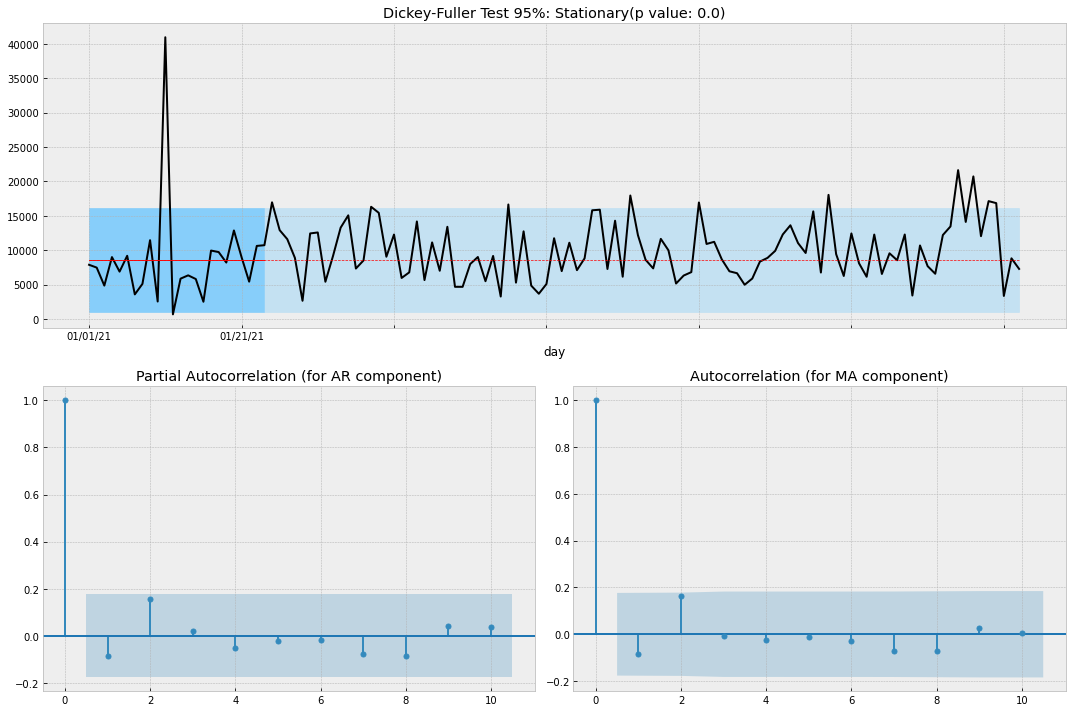

In [19]:
test_stationarity_acf_pacf(ts, sample=0.20, maxlag=10)

The result of the Dickey-Fuller test indicates that the time series might be stationary since p<0.01 and almost 0.00


Although differencing is not need as we rejected Null Hypothesis, but still We will run the same tests after differencing the time series. Differencing can help stabilize the mean by removing changes in 
the level of observations, and therefore eliminating (or reducing) trend and seasonality. 

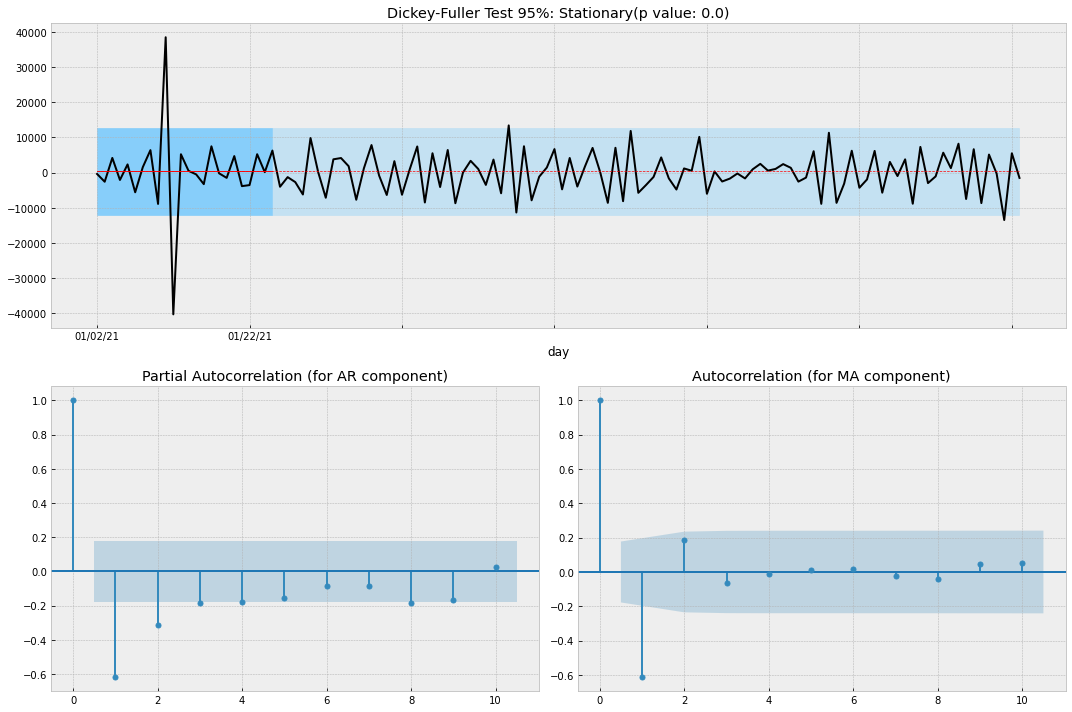

In [20]:
diff_ts = ts - ts.shift(1)
diff_ts = diff_ts[(pd.notnull(diff_ts))]
test_stationarity_acf_pacf(diff_ts, sample=0.20, maxlag=10)

The result of the Dickey-Fuller test indicates that the time series might be stationary since p<0.01 and almost 0.00


This time we can reject the null hypothesis of non-stationarity with a confidence level of 95% well (p-value is 0.000).
We can conclude that it is better to assume that the time series is stationary. And can easily spot it by looking at the plot.

In [21]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

        
adfuller_test(df_test['total_sales'])

ADF Test Statistic : -6.850706766368208
p-value : 1.6971850885053773e-09
#Lags Used : 1
Number of Observations Used : 121
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


so our test was right 

#Now lets check the seasonality in our sales-data, the objective is to check whether the any occasion had effect on the sale #and forecast.The goal of the study is to understand what kind of seasonality is affecting the data (weekly seasonality if it presents fluctuations every 7). We will consider weekly seasonality as we are working on 4 months data.
#There is a super useful function into the statsmodel library that allows us to decompose the time series. 
#This function splits the data into 3 components: trend, seasonality and residuals.

In this case lets try with 2 days, 7 days and 30 days, 
and lets check results. are better with a weekly seasonality (s = 7).

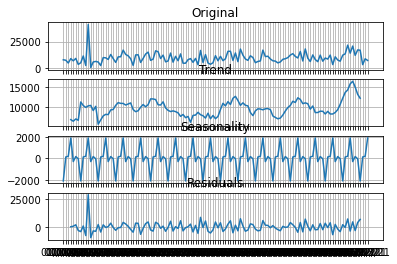

In [22]:
decomposition = smt.seasonal_decompose(ts, period=7)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid   
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=False)
ax[0].plot(ts)
ax[0].set_title('Original')
ax[0].grid(True) 
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[1].grid(True)  
ax[2].plot(seasonal)
ax[2].set_title('Seasonality')
ax[2].grid(True)  
ax[3].plot(residual)
ax[3].set_title('Residuals')
ax[3].grid(True)

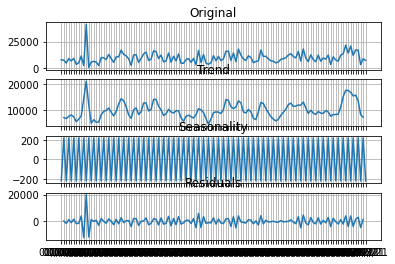

In [23]:
decomposition = smt.seasonal_decompose(ts, period=2)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid   
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=False)
ax[0].plot(ts)
ax[0].set_title('Original')
ax[0].grid(True) 
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[1].grid(True)  
ax[2].plot(seasonal)
ax[2].set_title('Seasonality')
ax[2].grid(True)  
ax[3].plot(residual)
ax[3].set_title('Residuals')
ax[3].grid(True)

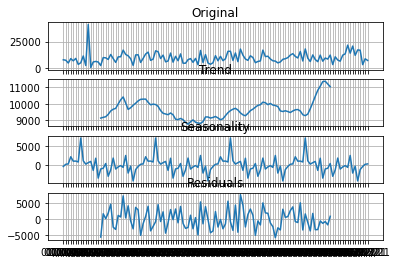

In [24]:
decomposition = smt.seasonal_decompose(ts, period=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid   
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=False)
ax[0].plot(ts)
ax[0].set_title('Original')
ax[0].grid(True) 
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[1].grid(True)  
ax[2].plot(seasonal)
ax[2].set_title('Seasonality')
ax[2].grid(True)  
ax[3].plot(residual)
ax[3].set_title('Residuals')
ax[3].grid(True)

Conclusion:
Usually choose the seasonal parameter that leads to smaller residuals.But results are better with a weekly seasonality (s = 7).
And also shows increasing trend in the sales. We can include a linear trend component into out forecasting models,
we can train the model on the raw data including outliers and on the processed data without outliers and test which one performs better.We know the time series is not stationary and therefore we should use an AR-I-MA model instead of an ARMA.
we can include a weekly seasonal component into out forecasting models.

Final Thoughts on Autocorrelation and Partial Autocorrelation
Identification of an AR model is often best done with the PACF.
For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
Identification of an MA model is often best done with the ACF rather than the PACF.

For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

p,d,q p AR model lags d differencing q MA lags

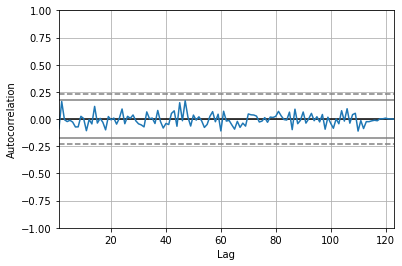

In [25]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_test['total_sales'])
plt.show()

In [26]:
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [27]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(df_test['total_sales'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.total_sales   No. Observations:                  122
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1213.290
Method:                       css-mle   S.D. of innovations           4942.072
Date:                Sat, 08 May 2021   AIC                           2434.579
Time:                        19:01:35   BIC                           2445.795
Sample:                             1   HQIC                          2439.135
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  18.4387     11.460      1.609      0.108      -4.022      40.899
ar.L1.D.total_sales    -0.0976      0.090     -1.082      0.279      -0.274       0.079
ma.L1.D.total_sales    -1.0000      0.025    -39.679      0.000      -1.049      -0.951
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -10.2477           +0.0000j           10.2477            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

lets try to forecast model on our data

<AxesSubplot:>

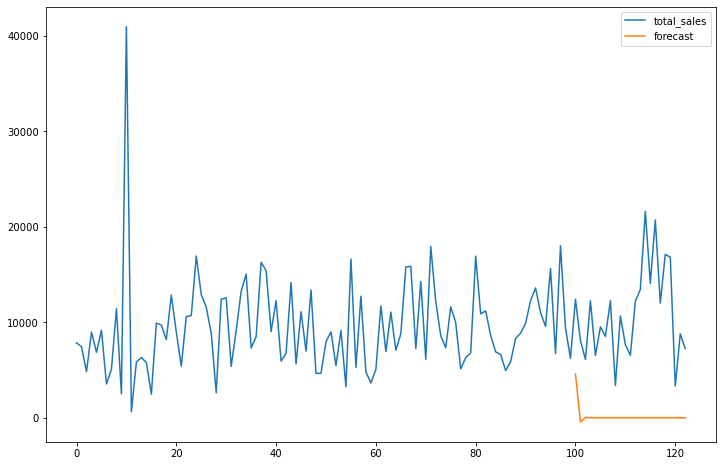

In [28]:
df_test['forecast']=model_fit.predict(start=100,end=123,dynamic=True)
df_test[['total_sales','forecast']].plot(figsize=(12,8))

we get some wrong prediction since we are using assuming as seasonality of 1 week and ARIMA doesn't  hold good here.

In [29]:
import statsmodels.api as sm #we will be using SARIMA

In [30]:
model=sm.tsa.statespace.SARIMAX(df_test['total_sales'],order=(1, 1, 1),seasonal_order=(1,1,0,7))
results=model.fit()

<AxesSubplot:>

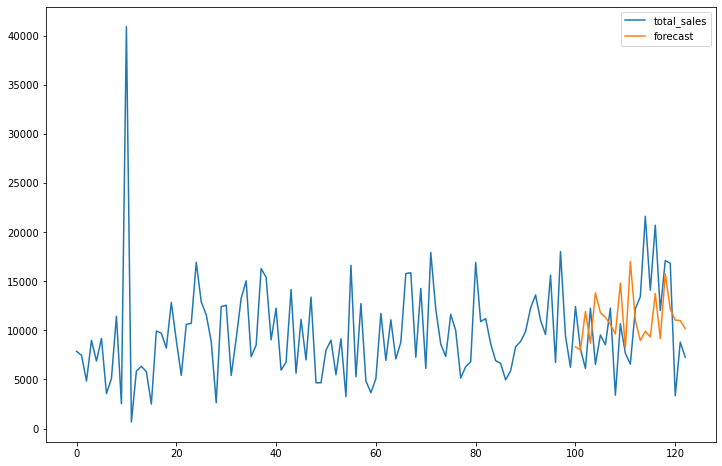

In [31]:
df_test['forecast']=results.predict(start=100,end=123,dynamic=True)
df_test[['total_sales','forecast']].plot(figsize=(12,8))

From above result and observation we got some decent results and it actually close to real data

#lets run the code and forecast the results for future event we assume for 2 months

In [32]:
x = ['05','06','07']
dates = []

for months in x:
    if(months=='05'):
        for i in range(28):
            if(0<=i<=9):
                date = '05/0' + str(i+4)+"/21"  
                dates.append(date)
            else:
                date = '05/' + str(i+4)+"/21"  
                dates.append(date)
                
    if(months=='06'):
        for i in range(30):
            if(0<=i<=9):
                date = '06/0' + str(i)+"/21"  
                dates.append(date)
            else:
                date = '07/' + str(i)+"/21"  
                dates.append(date)
    if(months=='07'):
        for i in range(10):
            if(0<=i<=9):
                date = '07/0' + str(i)+"/21"  
                dates.append(date)
            else:
                date = '07/' + str(i)+"/21"  
                dates.append(date)
            
future_dates=pd.DataFrame(dates, columns=['day'])
#future_datest_df=pd.DataFrame(index=future_dates[0:],columns=df_test.columns)
future_dates

,day
0,05/04/21
1,05/05/21
2,05/06/21
3,05/07/21
4,05/08/21
...,...
63,07/05/21
64,07/06/21
65,07/07/21
66,07/08/21


In [36]:
index=future_dates[0:]
future=pd.concat([df_test,index])
future.reset_index(inplace = True, drop = True)

In [37]:
future

,day,total_sales,forecast
0,01/01/21,7866.70,NaN
1,01/02/21,7458.70,NaN
2,01/03/21,4840.25,NaN
3,01/04/21,8985.40,NaN
4,01/05/21,6873.30,NaN
...,...,...,...
186,07/05/21,NaN,NaN
187,07/06/21,NaN,NaN
188,07/07/21,NaN,NaN
189,07/08/21,NaN,NaN


In [38]:
mod=sm.tsa.statespace.SARIMAX(df_test['total_sales'],order=(1, 1, 1),seasonal_order=(1,1,0,7))
result=mod.fit()

<AxesSubplot:>

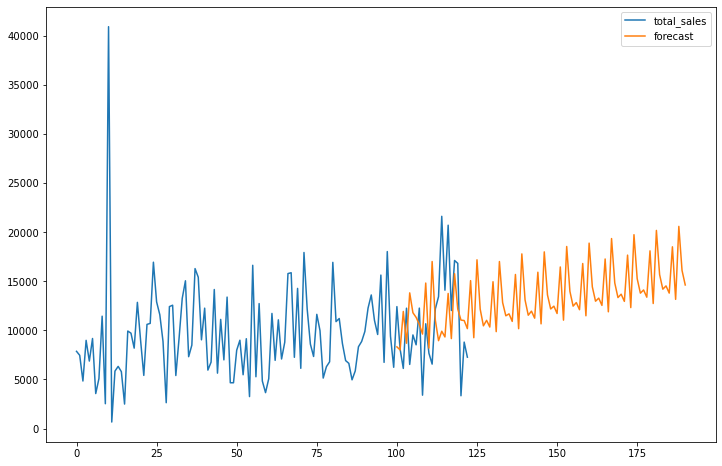

In [42]:
future['forecast'] = result.predict(start = 100, end = 190, dynamic= True)  
future[['total_sales', 'forecast']].plot(figsize=(12, 8)) 

Here from the above plot we can se sum forecast of the next 2 months as derived by checking the trend in given dataset applying
machine learning and statistical modelling.